In [1]:
from PIL import Image
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt 
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score


import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
from torchvision import transforms




RS=7

In [2]:
train_files = pd.read_csv("train.csv")
test_files = pd.read_csv("test.csv")

In [3]:
# separate the labels in a target df
labels = train_files["label"]

# drop the labels from the training set as we will use it from a separate df
train_files.drop(labels=["label"], axis=1, inplace=True)

# Data Exploration

Prior to actually developing a solution, we should check how our data is distributed. Our main questions are:
- Are the classes balanced?

In [4]:
print(labels.value_counts())
print(len(labels))

1    4684
7    4401
3    4351
9    4188
2    4177
6    4137
0    4132
4    4072
8    4063
5    3795
Name: label, dtype: int64
42000


Hence the labels are fairly well distributed, but we have less samples for 5, which can lead to poor performance. Maybe we should use data augmentation to make the distribution more equal.

Now let's visualize some images 

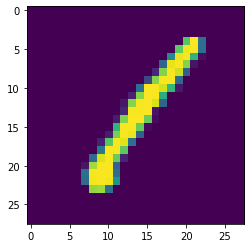

In [5]:
# transform into a tensor for later use
test_tensor = torch.from_numpy(train_files.iloc[0].values)
test_tensor_form = torch.reshape(test_tensor, (28, 28))

test_np_form = test_tensor_form.numpy()
plt.imshow(test_np_form)


Now that we know how to see the images and handle the formatting properly, we may create the dataloader to help us in training

# Development: Reformat data

In [6]:
# we need to normalize the input
print(torch.std_mean(torch.from_numpy(train_files.values).float()/255))
transform = transforms.Compose([transforms.Normalize((0.1310,), (0.3085,))])

shaped_data = []

for idx, col in train_files.iterrows():
    col_tens = torch.tensor(col.values.astype(np.float32))
    col_tens = torch.reshape(col_tens, (1, 28, 28))
    col_tens = transform(col_tens)

    shaped_data.append(col_tens)

shaped_data_test = []
print(len(test_files))
for idx, col in test_files.iterrows():
    col_tens = torch.tensor(col.values.astype(np.float32))
    col_tens = torch.reshape(col_tens, (1, 28, 28))
    col_tens = transform(col_tens)

    shaped_data_test.append(col_tens)



(tensor(0.3085), tensor(0.1310))
28000


In [7]:
# print(len(shaped_data), len(shaped_data_test))

# Development: Train-Validation segregation

To assure that we are improving during training, we should select some samples to validate during the process. 

In [8]:

X_train, X_valid, y_train, y_valid = train_test_split(shaped_data, 
                                                      labels, 
                                                      test_size=0.3, 
                                                      random_state=RS)


# Development: Dataloader

The dataloader is important to assure that our training runs smoothly and we can make different tests. https://stanford.edu/~shervine/blog/pytorch-how-to-generate-data-parallel provides a good reference on torch dataloaders!

torch.Size([28, 28])

In [9]:

class trainData(Dataset):

    def __init__(self, X_data, y_data):
        self.X_data = X_data
        self.y_data = y_data

        self.transform = transform

    def __getitem__(self, index):
        X_data = self.X_data[index] 
        y_data = self.y_data[index]
        
        return X_data, y_data

    def __len__(self):
        return len(self.X_data)


class testData(Dataset):

    def __init__(self, X_data):
        self.X_data = X_data

    def __getitem__(self, index):
        X_data = self.X_data[index] 
        
        return X_data

    def __len__(self):
        return len(self.X_data)



train_data = trainData(X_train, torch.FloatTensor(y_train.values))

valid_data = trainData(X_valid, torch.FloatTensor(y_valid.values))

test_data = testData(shaped_data_test)



In [10]:
batch_size = 128

train_loader = DataLoader(
        dataset=train_data,
        batch_size=batch_size)
        # shuffle=True,
        # num_workers=12,
        # pin_memory=True)
valid_loader = DataLoader(
        dataset=valid_data,
        batch_size=len(valid_data))
test_loader = DataLoader(
        dataset=test_data,
        batch_size=len(test_data))




In [11]:
class CNN (nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)

        self.fc1 = nn.Linear(256, 100)
        self.fc2 = nn.Linear(100, 50)
        self.fc3 = nn.Linear(50, 10)
        self.dropout = nn.Dropout(p=0.25)
    
    def forward(self, x):
        x = F.max_pool2d(F.relu(self.conv1(x)), (2,2))
        x = F.max_pool2d(F.relu(self.conv2(x)), (2,2))

        x = x.view(-1, self.num_flat_features(x))

        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

    def num_flat_features(self, x):
        size = x.size()[1:]  # all dimensions except the batch dimension
        num_features = 1
        for s in size:
            num_features *= s
        return num_features

cnn = CNN()
print(cnn)

CNN(
  (conv1): Conv2d(1, 6, kernel_size=(2, 2), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=256, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=50, bias=True)
  (fc3): Linear(in_features=50, out_features=10, bias=True)
  (dropout): Dropout(p=0.25, inplace=False)
)


In [12]:
# params = list(cnn.parameters())
# print(len(params))
# print(params[0].size())
# # input = torch.randn(1, 1, 28,28 ).to(device)
# input = X_train[0].unsqueeze(1)

# out = cnn(input)
# print(out)

# Training

In [13]:
len(valid_data)

12600

In [14]:
def multi_acc(y_pred, y_orig):
    y_pred_softmax = torch.log_softmax(y_pred, dim=1)
    _, y_pred_tags = torch.max(y_pred_softmax, dim=1)

    correct_pred = (y_pred_tags == y_orig).float()
    acc = correct_pred.sum() / len(correct_pred)

    acc *= 100
    acc = torch.round(acc)

    return acc

In [15]:
n_epochs = 150
device = torch.device("cuda:0")
cnn = cnn.to(device)
print(cnn)
cnn.train()


CNN(
  (conv1): Conv2d(1, 6, kernel_size=(2, 2), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=256, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=50, bias=True)
  (fc3): Linear(in_features=50, out_features=10, bias=True)
  (dropout): Dropout(p=0.25, inplace=False)
)


CNN(
  (conv1): Conv2d(1, 6, kernel_size=(2, 2), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=256, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=50, bias=True)
  (fc3): Linear(in_features=50, out_features=10, bias=True)
  (dropout): Dropout(p=0.25, inplace=False)
)

Epoch: 10, Loss: 0.06336, Train ACC: 97.93913 Valid ACC:98.0
Epoch: 20, Loss: 0.04167, Train ACC: 98.53043 Valid ACC:98.0
Epoch: 30, Loss: 0.02918, Train ACC: 98.91304 Valid ACC:98.0
Epoch: 40, Loss: 0.02268, Train ACC: 99.18261 Valid ACC:98.0
Epoch: 50, Loss: 0.01570, Train ACC: 99.39565 Valid ACC:98.0
Epoch: 60, Loss: 0.01688, Train ACC: 99.39130 Valid ACC:98.0
Epoch: 70, Loss: 0.01444, Train ACC: 99.46957 Valid ACC:99.0
Epoch: 80, Loss: 0.01243, Train ACC: 99.50870 Valid ACC:99.0
Epoch: 90, Loss: 0.01343, Train ACC: 99.56087 Valid ACC:98.0
Epoch: 100, Loss: 0.01071, Train ACC: 99.56522 Valid ACC:98.0
Epoch: 110, Loss: 0.00895, Train ACC: 99.64783 Valid ACC:99.0
Epoch: 120, Loss: 0.01059, Train ACC: 99.63043 Valid ACC:99.0
Epoch: 130, Loss: 0.00706, Train ACC: 99.70870 Valid ACC:99.0
Epoch: 140, Loss: 0.01236, Train ACC: 99.60435 Valid ACC:98.0
Epoch: 150, Loss: 0.00951, Train ACC: 99.73043 Valid ACC:98.0


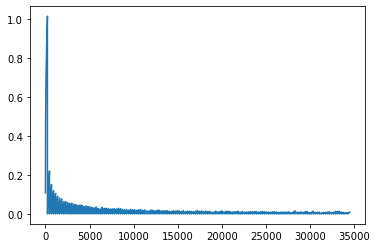

In [16]:
optimizer = optim.Adam(cnn.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()
train_losses = []
train_accs = []

for epoch in range(1, n_epochs+1):
    epoch_train_loss = 0
    epoch_train_acc = 0
    for i, data in enumerate(train_loader):
        X_batch, y_batch = data
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()

        # print(X_batch.shape, X_batch.unsqueeze(1).shape)

        y_train_pred = cnn(X_batch)
        # print(y_train_pred[1], y_batch[1])
        # y_pred_softmax = torch.log_softmax(y_train_pred, dim=1)
        # _, y_pred_tags = torch.max(y_pred_softmax, dim=1)
        # print(y_pred_tags[1])

        # print(y_train_pred.shape, y_batch.shape)
        loss = criterion(y_train_pred, y_batch.long())
        train_acc = multi_acc(y_train_pred, y_batch)

        loss.backward()
        optimizer.step()
        
        epoch_train_loss += loss.item()
        epoch_train_acc += train_acc.item()
        
        train_accs.append(epoch_train_acc/len(train_loader))
        train_losses.append(epoch_train_loss/len(train_loader))
        

    # print(f'Epoch {epoch}, Loss: {epoch_loss/len(train_loader):.5f}')

    if epoch % 10 == 0:
        cnn.eval()
        with torch.no_grad():
            y_pred = []
            for X_batch, y_batch in valid_loader:
                X_batch = X_batch.to(device)
                y_batch = y_batch.to(device)
                y_valid_pred = cnn(X_batch)             

                val_acc = multi_acc(y_valid_pred, y_batch)
            
        # val_acc = accuracy_score(y_valid.values, y_pred.cpu().numpy())
        print(f"Epoch: {epoch}, Loss: {epoch_train_loss/len(train_loader):.5f}, Train ACC: {epoch_train_acc/len(train_loader):.5f} Valid ACC:{val_acc}")
        cnn.train()

plt.plot(train_losses)



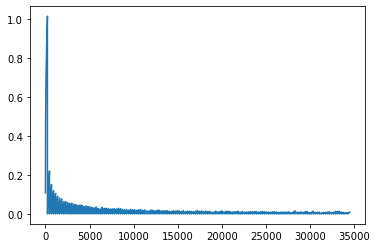

In [17]:
plt.plot(train_losses)
# print(corrects)

# Testing

In [18]:
# we need to normalize the input
# print(torch.std_mean(torch.from_numpy(train_files.values).float()/255))
transform = transforms.Compose([transforms.Normalize((0.1310,), (0.3085,))])




In [19]:
cnn.eval()
with torch.no_grad():
    y_pred = []
    for X_batch in test_loader:
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)
        y_test_pred = cnn(X_batch)             

        y_pred_softmax = torch.log_softmax(y_test_pred, dim=1)
        _, y_pred_tags = torch.max(y_pred_softmax, dim=1)
            



In [20]:
len(y_pred_tags.cpu().numpy())


28000

In [22]:
result = pd.DataFrame()
result["ImageId"]= list(range(1, len(y_pred_tags.cpu().numpy())+1))
result["Label"] = y_pred_tags.cpu().numpy()
result.to_csv("submission.csv", index=False)